# Parsing measurement data

In [1]:
import math

def lmap(f,x):
    return list(map(f,x))

def process_raw_decay_data(id, startTime = -1, threshold = 0.7, floating_avg = True):
    peaks = []

    # startTime == -1 => auto cutoff
    auto_cutoff = False
    if(startTime == -1):
        auto_cutoff = True
        startTime = 0

    with open(f"./inputs/Spinner_{id}_decay_rate.csv") as inp:
        lines = inp.read().split("\n")

        startInd = 1
        while (float(lines[startInd].split(",")[0]) < startTime): startInd += 1
        
        hitPeak = False
        startPeak = 0
        endPeak = 0
        for i in range(startInd, len(lines)-1):
            row = lines[i].split(",")

            if (float(row[1]) >= threshold and not hitPeak):
                hitPeak = True
                startPeak = float(row[0])


            if (float(row[1]) < threshold and hitPeak):
                hitPeak = False
                endPeak = float(row[0])

                peaks.append((endPeak+startPeak)/2)                

    results = {}
    interval = 1
    step = 0.1
    curTime = startTime
    x = 0
    while x < len(peaks):
        if (peaks[x] > curTime+interval):
            curTime += step
            x = 0
        elif (peaks[x] > curTime and peaks[x] < curTime+interval):
            if (not curTime in results): results[curTime] = 1
            else: results[curTime] += 1
            
        x += 1

    cutoff_val = math.inf
    if(auto_cutoff):
        cutoff_val = 0

    if(floating_avg):   
        with open(f"./outputs/Spinner_{id}_decay_rate_PROCESSED_FLOATING_AVERAGE.csv", 'w') as res:
            res.write("t, peaks/s, omega \n")
            for x in range(4, len(results.keys())):
                flAverage = 0
                for y in range(5):
                    flAverage += results[list(results.keys())[x-y]]
                flAverage = flAverage/5

                if(auto_cutoff):
                    if(flAverage > cutoff_val):
                        cutoff_val = flAverage

                if(flAverage < cutoff_val):
                    res.write(str(round(list(results.keys())[x-y], 1)) + "," + str(flAverage) + "," + str(flAverage*2*math.pi/3) + "\n")

        return f"./outputs/Spinner_{id}_decay_rate_PROCESSED_FLOATING_AVERAGE.csv"
    else:
        with open(f"./outputs/Spinner_{id}_decay_rate_PROCESSED.csv", 'w') as res:
            res.write("t, peaks/s \n")
            for key in results.keys():
                res.write(str(round(key, 1)) + "," + str(results[key]) + "\n")
        
        return f"./outputs/Spinner_{id}_decay_rate_PROCESSED.csv"


In [2]:
processed_paths = []
# for i in range(1,8,1):
for i in range(1,2,1):
    out_path = process_raw_decay_data(i, -1, 0.7)
    processed_paths.append(out_path)

# Fitting for $\alpha$, $\beta$, $\gamma$, $c_1$

$$
\omega(t) = -\frac{\sqrt{4\alpha\gamma - \beta^2} \tan{(\frac{1}{2}\sqrt{4\alpha\gamma - \beta^2}(t-c_1)})-\beta}{2\gamma}
$$

[115.5386083360729] 0.2204086816718552 0.00018882943185321167 0.00026124506671733165 174.46584909160697


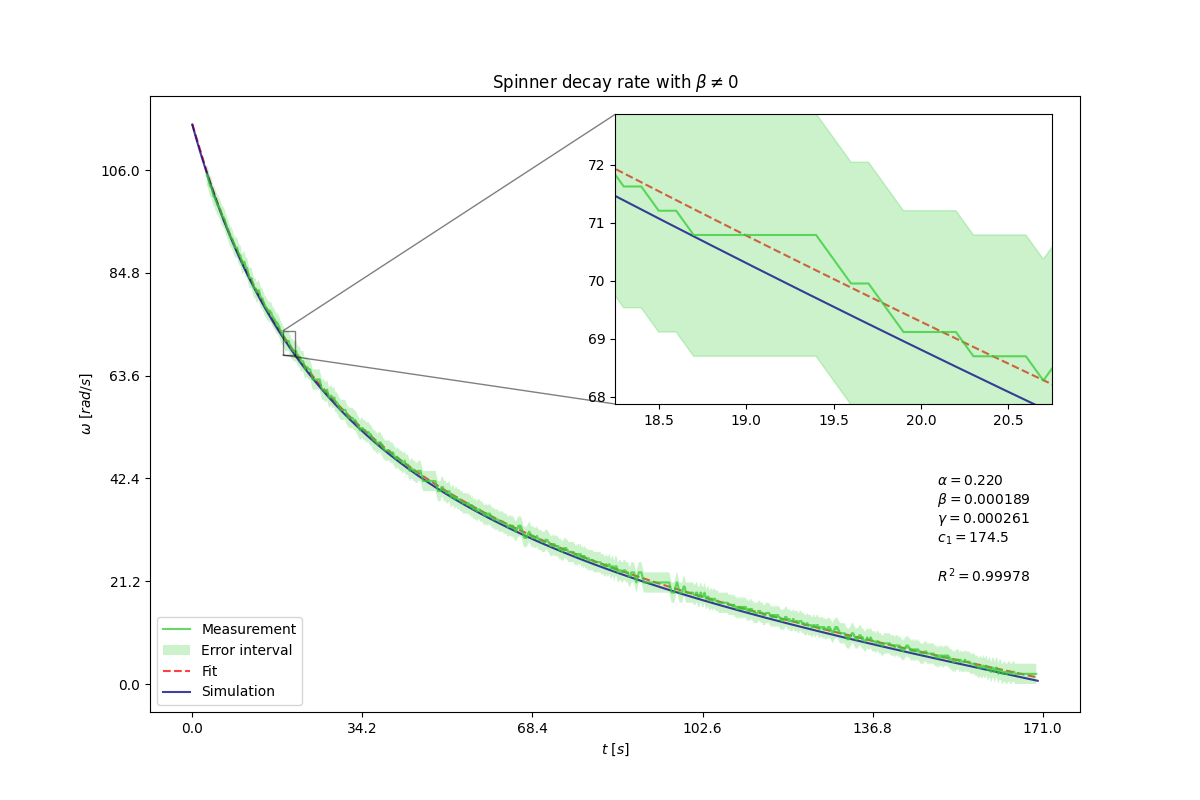

In [3]:
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

%matplotlib widget

alphas = []
betas = []
gammas = []
cs = []
omega_0s = []
R_squares = []

for i in range(len(processed_paths)):
    path = processed_paths[i]
    fig, ax = plt.subplots(figsize=(12, 8))
    axins = None
    
    with open(path, "r") as read:
        data = read.readlines()[1:]
        data = lmap(lambda row: row.rstrip().split(","), data)

        xdata = lmap(lambda row: float(row[0]), data)
        ydata = lmap(lambda row: float(row[2]), data)

        omega_0s.append(ydata[0])

        def ω(time, alpha, beta, gamma, c_1):
            u = math.sqrt(4 * alpha * gamma - beta**2)
            return [
                -(u * math.tan(1/2 * u * (t - c_1)) - beta)/(2*gamma)
                for t in time
            ]
            
        [alpha, beta, gamma, c], pcov = opt.curve_fit(
            ω,
            xdata,
            ydata,
            bounds=(
                [0, 0, 0, 0],  # min
                [1, 0.1, 0.01, math.inf],  # max
            ),
            p0=[0.21, 0.00001, 0.00025, 170],
            max_nfev=50000
        )
        perr = np.sqrt(np.diag(pcov))

        # calc R^2
        residuals = np.array(ydata) - np.array(ω(xdata, *[alpha, beta, gamma, c]))
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((np.array(ydata) - np.mean(ydata))**2)
        r_squared = 1 - (ss_res / ss_tot)

        alphas.append(alpha)
        betas.append(beta)
        gammas.append(gamma)
        cs.append(c)
        R_squares.append(r_squared)

        # INSET
        x1 = xdata[round(len(xdata)/10)] - 1.25
        x2 = x1 + 2.5
        y1 = ydata[round(len(ydata)/10)] - 2.5 
        y2 = ydata[round(len(ydata)/10)] + 2.5
        axins = ax.inset_axes(
            [0.5, 0.5, 0.47, 0.47],
            xlim=(x1, x2), ylim=(y1, y2))
        
        # Measurement
        plt.plot(xdata, ydata, label="Measurement", color="limegreen", zorder=2, alpha=0.75)
        axins.plot(xdata, ydata, label="Measurement", color="limegreen", zorder=2, alpha=0.75)
        
        # ERROR
        plt.fill(
            xdata + xdata[::-1], 
            lmap(lambda y: y+2/3 * math.pi, ydata) +
            lmap(lambda y: y-2/3 * math.pi, ydata)[::-1], 
            label="Error interval",
            color="limegreen",
            edgecolor="none",
            alpha = 0.25
        )
        axins.fill(
            xdata + xdata[::-1], 
            lmap(lambda y: y+2/3 * math.pi, ydata) +
            lmap(lambda y: y-2/3 * math.pi, ydata)[::-1], 
            color="limegreen",
            alpha = 0.25
        )
        
        plt.xlabel("$t$ $[s]$")
        plt.ylabel("$\omega$ $[rad/s]$")

        plt.xticks(np.linspace(0, round(max(xdata)) + 1, 6))
        plt.yticks(np.linspace(0, round(max(ydata)) + 1, 6))

        plt.title(f"Spinner decay rate with $\\beta \\neq 0$")
        plt.text(max(xdata) * 0.8, max(ydata) * 0.2, 
                f"""
                $\\alpha={alpha:.3f}$
                $\\beta={beta:.6f}$
                $\\gamma={gamma:.6f}$
                $c_1={c:.1f}$
                
                $R^2={r_squared:.5f}$""")

        # FIT
        print(ω([0], alpha, beta, gamma, c), alpha, beta, gamma, c)
        plt.plot([0, *xdata], ω([0, *xdata], alpha, beta, gamma, c), color="red", linestyle="--", label="Fit", zorder=0, alpha=0.75)
        axins.plot([0, *xdata], ω([0, *xdata], alpha, beta, gamma, c), color="red", linestyle="--", label="Fit", zorder=0, alpha=0.75)
    
    # SIMULATION
    try:
        with open(f"./sim/sim_spinner{i+1}_with_beta.csv") as read:
            data = read.readlines()[1:]
            data = lmap(lambda row: row.rstrip().split(","), data)

            xdata = lmap(lambda row: float(row[0]), data)
            ydata = lmap(lambda row: float(row[1]), data)
            
            plt.plot(xdata, ydata, label="Simulation", color="navy", linestyle="-", zorder=1, alpha=0.75)
            axins.plot(xdata, ydata, label="Simulation", color="navy", linestyle="-", zorder=1, alpha=0.75)
    except Exception as e:
        print(e)
        pass

    ax.indicate_inset_zoom(axins, edgecolor="black")
        
    plt.legend(loc="lower left")
    
plt.savefig("spinner_decay_with_beta.png", format="png", dpi=1500)
    


In [4]:
print(alphas, betas)
print(np.max(betas), np.average(betas), np.max(min))

[0.2204086816718552] [0.00018882943185321167]
0.00018882943185321167 0.00018882943185321167 <built-in function min>
